In [ ]:
# Dataset taken from https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [49]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.metrics import error_rate
import numpy as np

In [92]:
path = Path('dataset/cell_images'); path

PosixPath('dataset/cell_images')

In [31]:
path.ls()

[PosixPath('dataset/cell_images/.DS_Store'),
 PosixPath('dataset/cell_images/Parasitized'),
 PosixPath('dataset/cell_images/Uninfected')]

# Data Exploration

In [74]:
import os

In [50]:
np.random.seed(42)

In [44]:
path_image_parasitized = Path('dataset/cell_images/Parasitized/')
path_image_uninfected = Path('dataset/cell_images/Uninfected/')

In [72]:
parasitized_images = get_image_files(path_image_parasitized)[:10]
parasitized_images

[PosixPath('dataset/cell_images/Parasitized/C118P79ThinF_IMG_20151002_105018_cell_150.png'),
 PosixPath('dataset/cell_images/Parasitized/C189P150ThinF_IMG_20151203_142224_cell_84.png'),
 PosixPath('dataset/cell_images/Parasitized/C91P52ThinF_IMG_20150821_123116_cell_189.png'),
 PosixPath('dataset/cell_images/Parasitized/C84P45ThinF_IMG_20150818_101226_cell_98.png'),
 PosixPath('dataset/cell_images/Parasitized/C144P105ThinF_IMG_20151015_163432_cell_310.png'),
 PosixPath('dataset/cell_images/Parasitized/C136P97ThinF_IMG_20151005_141803_cell_131.png'),
 PosixPath('dataset/cell_images/Parasitized/C65P26N_ThinF_IMG_20150818_154050_cell_177.png'),
 PosixPath('dataset/cell_images/Parasitized/C60P21thinF_IMG_20150804_105034_cell_105.png'),
 PosixPath('dataset/cell_images/Parasitized/C109P70ThinF_IMG_20150930_103811_cell_159.png'),
 PosixPath('dataset/cell_images/Parasitized/C176P137NThinF_IMG_20151201_122708_cell_126.png')]

In [79]:
path, dirs, files = next(os.walk(path_image_parasitized))
file_count = len(files)
print("Number of images for parasitized:", file_count)

Number of images for parasitized: 13780


torch.Size([169, 148])

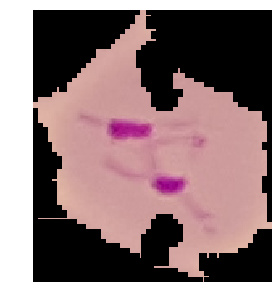

In [83]:
images_para = open_image(parasitized_images[np.random.randint(0, 9)])
images_para.show(figsize=(5,5))
images_para.size

In [61]:
uninfected_images = get_image_files(path_image_uninfected)[:10]
uninfected_images

[PosixPath('dataset/cell_images/Uninfected/C13NThinF_IMG_20150614_131318_cell_179.png'),
 PosixPath('dataset/cell_images/Uninfected/C205ThinF_IMG_20151106_152003_cell_21.png'),
 PosixPath('dataset/cell_images/Uninfected/C230ThinF_IMG_20151112_150647_cell_1.png'),
 PosixPath('dataset/cell_images/Uninfected/C134P95ThinF_IMG_20151005_121834_cell_65.png'),
 PosixPath('dataset/cell_images/Uninfected/C141P102ThinF_IMG_20151005_214836_cell_132.png'),
 PosixPath('dataset/cell_images/Uninfected/C167P128ReThinF_IMG_20151201_105559_cell_61.png'),
 PosixPath('dataset/cell_images/Uninfected/C218ThinF_IMG_20151106_144337_cell_57.png'),
 PosixPath('dataset/cell_images/Uninfected/C182P143NThinF_IMG_20151201_171950_cell_93.png'),
 PosixPath('dataset/cell_images/Uninfected/C181P142ThinF_IMG_20151127_160616_cell_54.png'),
 PosixPath('dataset/cell_images/Uninfected/C142P103ThinF_IMG_20151005_223257_cell_18.png')]

In [80]:
path, dirs, files = next(os.walk(path_image_uninfected))
file_count = len(files)
print("Number of images for uninfected:", file_count)

Number of images for uninfected: 13780


torch.Size([127, 127])

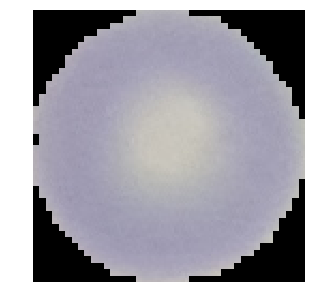

In [84]:
images_unin = open_image(uninfected_images[np.random.randint(0, 9)])
images_unin.show(figsize=(5,5))
images_unin.size

## Observations: 
- Data is evenly balanced in number of images for uninfected and infected
- Images aren't evenly sized.
- I assume purple cells are white blood cells and peach are red blood cells
- Not positive on what ThinF means. I assume it means thin slices of cells
- Unsure what the various versions of ReThinF, NThinF, ThinF, thinF, etc. denotes in the images


# Data Bunching
<input type="checkbox"> Combine uninfected & infected for training set
<input type="checkbox"> Resize images to uniform size


In [96]:
data = ImageDataBunch.from_folder(path, train=".",
                                  valid_pct=0.2, # Splits the dataset into 80/20% training/validation
                                  ds_tfms=get_transforms(do_flip = True, flip_vert = True, max_warp=0), # AFAIK images can be flipped any direction vertically, horizontally, 90 degrees in actual cell images
                                  size=256,bs=16 # Trying out a larger 256 size at first
                                 ).normalize(imagenet_stats)

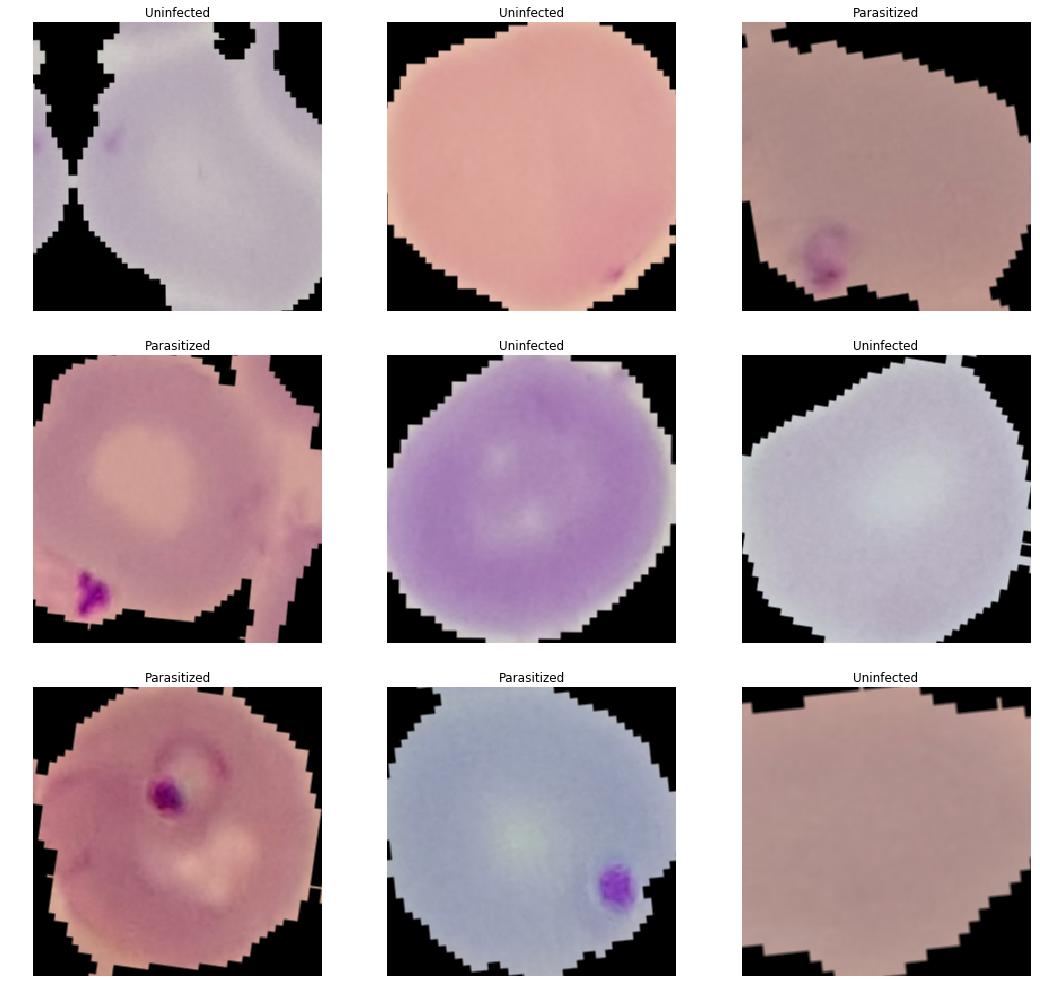

In [97]:
data.show_batch(rows=3, figsize=(15,14))

In [98]:
print(data.classes)
len(data.classes),data.c

['Parasitized', 'Uninfected']


(2, 2)

# Model Training

In [99]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/raymondmbp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:24, 3628226.36it/s] 


In [100]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
